In [ ]:
# !pip install machine_learning_datasets
# !pip install opencv-python==4.5.3.56
# !pip install pdpbox

# 해석 방법론 (피처 중요도)
1. sklearn 모델의 고유 매개변수를 사용한 피처 중요도
2. 순열 피처 중요도 (PFI)
3. 부분 의존도 플롯 해석 (PDP)
4. 개별 조건부 기대치 (ICE)

# Mission
1. 설문의 답과 출생 순서 사이의 관계
2. 그들의 경험적 연구에 사용할 수 있는 질문이 존재하는가

## Domain
형제자매 간의 역학 그리고 출생 순서에 따른 양육 방식이 성격에 어떠한 영향을 미치는가?  
- 프랜시스 골턴 : 첫째 아이를 더 높은 지능과 연관
- 브램 분크 : 막내와 질투를 연관
다양한 이론들이 존재하지만 문화간의 차이가 아주 중요하기 때문에 서구 이론은 다른 지역에 잘 통하지 않는다.  
<br>
범주는 총 3가지
    1. 첫째
    2. 둘째 (첫째도 아니고 막내도 아닌 위치)
    3. 막내

## Approch
- 모델의 고유 매개변수를 사용해 모델에 가장 큰 영향을 미치는 피처를 찾는다. (글로벌 모듈러 해석 방법론)
- PFI를 통한 더욱 신뢰성 있는 피처 중요도 탐색
- PDP를 사용해 가장 중요한 피처가 결과에 미치는 한계 효과 포착
- ICE 플롯을 사용해 개별 피처가 모델의 예측에 미치는 영향을 좀 더 세분화해서 시각화

## 데이터 딕셔너리
### 인구 통계학적 피처처
- age : 서수형. 참가자의 연 나이
- engnat : 이진 값. 영어가 모국어인지 여부. 1=예, 2=아니요
- gender : 범주형. 성별. 남서으 여성, 기타, 정의되지 않음
- birth : 서수형. 부모가 낳은 총 자녀 수. 1~10, 11=기타
- country: 범주형. 참가자의 국가. 2자리 코드
- birthorder : 서수형. 목표변수인 출생 순서. 1:첫째,2:중간,3:막내
### 기술적 피처
- source : 범주형. 성격 테스트에 도달한 방법. 1:구글에서 직접, 2:웹사이트 첫 페이지, 3:기타
- screensize : 서수형. 테스트에 사요된 화면 크기. 2:600픽셀 이상, 1:그보다 작음
- introelapse : 연속형. 성격 테스트 랜딩 페이지에서 보낸 시간(초)
- testelapse : 연속형. 성격 테스트 본문에 소요된 시간(초)
- endelapse : 연속형. 성격 테스트 종료 페이지에서 보낸 시간(초)


In [2]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, discriminant_analysis,ensemble, neural_network, inspection
import matplotlib.pyplot as plt
from pdpbox import pdp
from pycebox.ice import ice, ice_plot

/home/studio/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
birthorder_df = mldatasets.load("personality-birthorder", prepare=True)

https://openpsychometrics.org/_rawdata/FBPS-ValidationData.zip downloaded to /home/studio/바탕화면/ml/Classification/data/FBPS-ValidationData.zip
/home/studio/바탕화면/ml/Classification/data/FBPS-ValidationData.zip uncompressed to /home/studio/바탕화면/ml/Classification/data/FBPS-ValidationData
1 dataset files found in /home/studio/바탕화면/ml/Classification/data/FBPS-ValidationData folder
parsing /home/studio/바탕화면/ml/Classification/data/FBPS-ValidationData/FBPS-ValidationData/FBPS-ValidationData.csv


In [7]:
birthorder_df.shape

(25813, 97)

- 출생 순서 칼럼 : y / 그 외 : X

In [8]:
rand = 9
y = birthorder_df['birthorder']
X = birthorder_df.drop(['birthorder'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand)

- 의사 결정 트리, 그래디언 부스트 트리, 랜덤 포레스트, 로지스틱 회귀, 다층 퍼셉트론,LDA 여섯 가지 모델에 적합

In [9]:
class_models = {  
        #Tree
        'decision_tree':{'model': tree.\
                         DecisionTreeClassifier(max_depth=6, random_state=rand,\
                                                class_weight='balanced')},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.\
                             GradientBoostingClassifier(n_estimators=200,\
                                                        max_depth=4, subsample=0.5,\
                                                        learning_rate=0.05)},
        'random_forest':{'model':ensemble.\
                         RandomForestClassifier(max_depth=11, n_estimators=300,\
                                                max_features='sqrt', random_state=rand)},
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.\
                    LogisticRegression(multi_class='ovr', solver='lbfgs',\
                                       class_weight='balanced', max_iter=500)},
        #Discriminant Analysis
        'lda':{'model':discriminant_analysis.\
               LinearDiscriminantAnalysis(n_components=2)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(), neural_network.\
                                     MLPClassifier(hidden_layer_sizes=(11,),\
                                                   early_stopping=True, random_state=rand,\
                                                   validation_fraction=0.25, max_iter=500))}
    }

In [10]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] =\
        metrics.accuracy_score(y_train, y_train_pred)
    class_models[model_name]['Accuracy_test'] =\
        metrics.accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] =\
        metrics.recall_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Recall_test'] =\
        metrics.recall_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['Precision_train'] =\
        metrics.precision_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Precision_test'] =\
        metrics.precision_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['F1_test'] =\
        metrics.f1_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['MCC_test'] =\
        metrics.matthews_corrcoef(y_test, y_test_pred)

- MCC 기준 정렬 및 색상 코딩 적용

In [11]:
class_metrics = pd.DataFrame.\
    from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                      'Recall_train', 'Recall_test',\
                                      'Precision_train', 'Precision_test',\
                                      'F1_test', 'MCC_test']]
with pd.option_context('display.precision', 3):
    html = class_metrics.sort_values(by='MCC_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.43, high=0.63,\
                            subset=['Accuracy_train', 'Accuracy_test']).\
        background_gradient(cmap='viridis', low=0.63, high=0.43,
                            subset=['F1_test'])
html

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_test,MCC_test
decision_tree,0.497,0.464,0.497,0.464,0.541,0.494,0.441,0.246
logistic,0.496,0.493,0.496,0.493,0.498,0.494,0.492,0.232
gradient_boosting,0.622,0.494,0.622,0.494,0.633,0.488,0.481,0.227
mlp,0.522,0.494,0.522,0.494,0.517,0.485,0.480,0.223
lda,0.501,0.492,0.501,0.492,0.500,0.489,0.477,0.201
random_forest,0.912,0.484,0.912,0.484,0.921,0.478,0.447,0.198


In [12]:
print('NIR: %.4f' %\
      (y_train[y_train==1].shape[0]/y_train.shape[0]))

NIR: 0.4215


In [13]:
dt_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'dt_imp': class_models['decision_tree']['fitted'].\
                          feature_importances_})
gb_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'gb_imp': class_models['gradient_boosting']['fitted'].\
                          feature_importances_})
rf_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'rf_imp': class_models['random_forest']['fitted'].\
                         feature_importances_})

In [14]:
dt_rank_df = pd.DataFrame({'dt_rank':\
                           dt_imp_df['dt_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})
gb_rank_df = pd.DataFrame({'gb_rank':\
                           gb_imp_df['gb_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})
rf_rank_df = pd.DataFrame({'rf_rank':\
                           rf_imp_df['rf_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})

In [15]:
tree_ranks_df = pd.merge(\
                    pd.merge(\
                        pd.concat((dt_imp_df, dt_rank_df), axis=1),\
                        pd.concat((gb_imp_df, gb_rank_df), axis=1),\
                        'left'),\
                    pd.concat((rf_imp_df, rf_rank_df), axis=1),\
                    'left')
tree_ranks_df['avg_rank'] = (tree_ranks_df['dt_rank'] +\
                            tree_ranks_df['gb_rank'] + \
                            tree_ranks_df['rf_rank'])/3
tree_ranks_df.sort_values(by='avg_rank')

,name,dt_imp,dt_rank,gb_imp,gb_rank,rf_imp,rf_rank,avg_rank
28,birthn,0.851533,1,0.368877,1,0.196067,1,1.000000
81,testelapse,0.013708,3,0.037157,2,0.027307,2,2.333333
26,age,0.006679,7,0.030320,3,0.025065,3,4.333333
0,Q1,0.025340,2,0.025634,6,0.016135,6,4.666667
80,introelapse,0.005056,9,0.030149,4,0.022142,5,6.000000
...,...,...,...,...,...,...,...,...
89,country_GB,0.000000,90,0.001118,91,0.002023,91,90.666667
94,source_google,0.000000,95,0.000541,96,0.003204,82,91.000000
91,country_NZ,0.000000,92,0.001134,90,0.000690,93,91.666667
83,gender_undefined,0.000000,87,0.000684,94,0.000241,96,92.333333


In [16]:
print(class_models['logistic']['fitted'].coef_.shape)


(3, 96)


In [17]:
stdv = np.std(X_train, 0)
lr_imp_df = pd.DataFrame({\
                'name': X_train.columns,\
                'first_coef_norm':\
                          class_models['logistic']['fitted'].coef_[0] * stdv,\
                'middle_coef_norm':\
                          class_models['logistic']['fitted'].coef_[1] * stdv,\
                'last_coef_norm':\
                          class_models['logistic']['fitted'].coef_[2] * stdv}).\
            reset_index(drop=True)

In [18]:
class_priors = class_models['lda']['fitted'].priors_
print(class_priors)

[0.42147566 0.23701862 0.34150572]


In [19]:
lr_imp_df['coef_weighted_avg'] = (abs(lr_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lr_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lr_imp_df['last_coef_norm']) * class_priors[2])

In [20]:
lr_imp_df.\
    sort_values(by='coef_weighted_avg', ascending=False).style.\
    background_gradient(cmap='viridis', low=-0.1, high=0.1,\
                        subset=['first_coef_norm',\
                                'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.413244,1.355780,-0.406324,0.634279
0,Q1,0.110561,0.022303,-0.149013,0.102774
12,Q13,0.079389,-0.038199,-0.063697,0.064267
15,Q16,0.060196,-0.054041,-0.027473,0.047562
19,Q20,-0.060952,0.050666,0.022709,0.045454
1,Q2,0.019352,-0.080440,0.048795,0.043886
9,Q10,0.049691,-0.018913,-0.045739,0.041047
26,age,0.055312,-0.025544,-0.029116,0.039310
39,EST1,0.049835,-0.062190,-0.002981,0.036763
40,EST2,-0.051426,-0.006013,0.039464,0.036577


In [21]:
class_models['lda']['fitted'].coef_.shape

(3, 96)

In [22]:
lda_imp_df = pd.DataFrame({\
                'name': X_train.columns,\
                'first_coef_norm':\
                          class_models['lda']['fitted'].coef_[0] * stdv,\
                'middle_coef_norm':\
                          class_models['lda']['fitted'].coef_[1] * stdv,\
                'last_coef_norm':\
                          class_models['lda']['fitted'].coef_[2] * stdv}).\
            reset_index(drop=True)

In [23]:
lda_imp_df['coef_weighted_avg'] = (abs(lda_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lda_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lda_imp_df['last_coef_norm']) * class_priors[2])

In [24]:
lda_imp_df.\
    sort_values(by='coef_weighted_avg', ascending=False).style.\
    background_gradient(cmap='viridis', low=-0.1, high=0.1,\
                        subset=['first_coef_norm',\
                                'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.315051,1.002922,-0.307242,0.475423
0,Q1,0.090613,-0.012808,-0.102942,0.076382
12,Q13,0.056740,-0.033932,-0.046477,0.047829
51,AGR3,-0.039195,-0.005623,0.052276,0.035705
15,Q16,0.038815,-0.035811,-0.023050,0.032719
6,Q7,-0.004032,0.064381,-0.039707,0.030519
16,Q17,0.035050,-0.009894,-0.036390,0.029545
24,Q25,-0.034672,0.034036,0.019169,0.029227
77,OPN9,-0.033481,0.045381,0.009825,0.028223
19,Q20,-0.030615,0.038022,0.011395,0.025807


In [26]:
print(class_models['mlp']['fitted'][1].coefs_[0].shape)
print(class_models['mlp']['fitted'][1].coefs_[1].shape)

(96, 11)
(11, 3)


In [27]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['fitted']
    permutation_imp = inspection.permutation_importance(\
                        fitted_model, X_test, y_test, n_jobs=-1,\
                        scoring='accuracy', n_repeats=8,\
                        random_state=rand)
    class_models[model_name]['importances_mean'] =\
                        permutation_imp.importances_mean

In [28]:
perm_imp_df = pd.DataFrame({
                'name': X_train.columns,\
                'dt_imp': class_models['decision_tree']['importances_mean'],\
                'gb_imp': class_models['gradient_boosting']['importances_mean'],\
                'rf_imp': class_models['random_forest']['importances_mean'],\
                'log_imp': class_models['logistic']['importances_mean'],\
                'lda_imp': class_models['lda']['importances_mean'],\
                'mlp_imp': class_models['mlp']['importances_mean']}).\
            reset_index(drop=True)

In [29]:
perm_imp_df['avg_imp'] = (perm_imp_df['dt_imp'] + perm_imp_df['gb_imp'] +\
                         perm_imp_df['rf_imp'] + perm_imp_df['log_imp'] +\
                         perm_imp_df['lda_imp'] + perm_imp_df['mlp_imp'])/6

In [30]:
perm_imp_sorted_df = perm_imp_df.round(5).\
    sort_values(by='avg_imp', ascending=False)
perm_imp_sorted_df.style.\
    background_gradient(cmap='viridis_r', low=0, high=0.2,\
                        subset=['dt_imp', 'gb_imp', 'rf_imp',\
                                'log_imp', 'lda_imp', 'mlp_imp'])

,name,dt_imp,gb_imp,rf_imp,log_imp,lda_imp,mlp_imp,avg_imp
28,birthn,0.138500,0.105350,0.074610,0.113450,0.083300,0.109310,0.104090
0,Q1,0.008320,0.003480,0.000880,0.008980,0.011400,0.008230,0.006880
26,age,0.001070,0.002830,0.004110,0.001480,-0.000820,0.001580,0.001710
12,Q13,0.000980,-0.000450,0.001670,0.000790,0.004270,0.002830,0.001680
3,Q4,0.000000,0.000180,0.002050,0.002000,0.000900,0.002820,0.001320
63,CSN5,0.002040,0.001100,0.000130,0.001320,0.000920,0.001530,0.001170
14,Q15,0.000000,0.001190,0.001980,0.001820,0.000760,0.001230,0.001160
51,AGR3,0.000320,-0.001450,0.000810,0.001010,0.003100,0.002950,0.001120
59,CSN1,0.000000,0.000690,0.001350,0.001530,0.000030,0.002860,0.001080
16,Q17,0.001190,-0.001120,-0.000040,0.002990,0.001800,0.001060,0.000980


In [31]:
pd.DataFrame.\
    from_dict(class_models, 'index')[['Accuracy_test']] -\
    perm_imp_sorted_df.iloc[0,1:7].to_numpy().reshape((6,1))

,Accuracy_test
decision_tree,0.325639
gradient_boosting,0.38837
random_forest,0.409015
logistic,0.379918
lda,0.408777
mlp,0.385114


In [32]:
feature_names = ['birthn', 'Q1', 'Q13', 'age']
feature_labels = ['# of Births', 'Question #1',\
                  'Question #13', 'Age']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


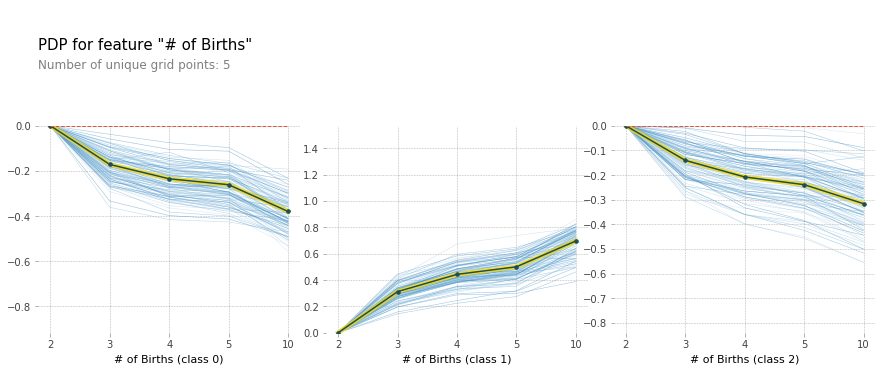

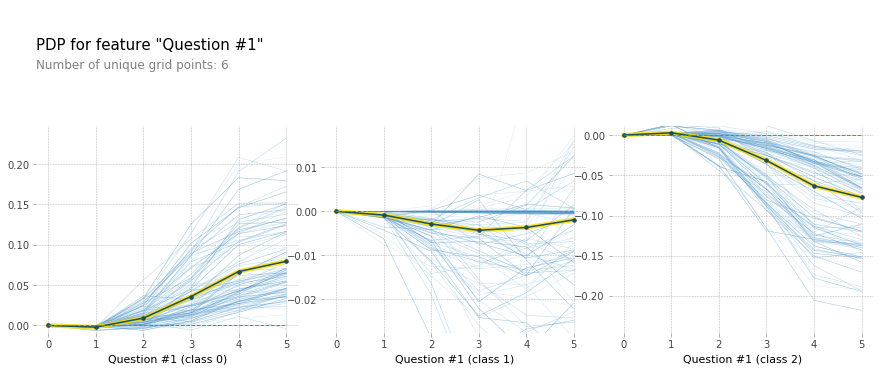

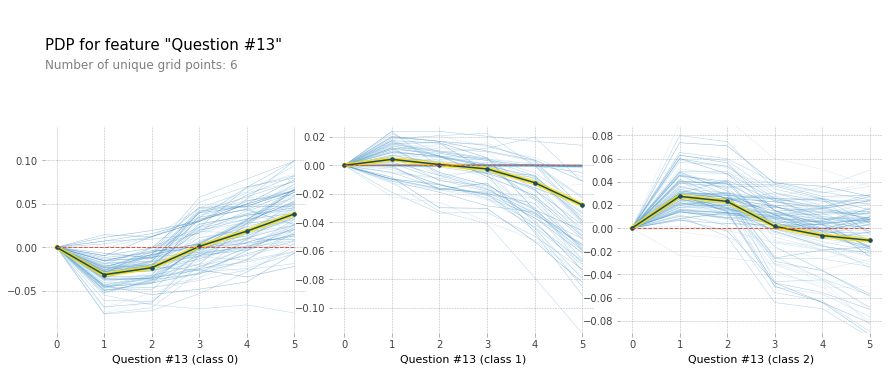

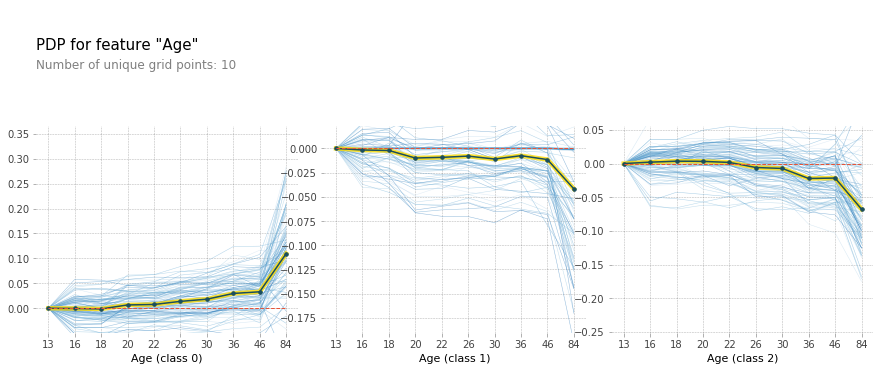

In [33]:
for i in range(len(feature_names)):
    pdp_feat_df = pdp.pdp_isolate(\
        model=class_models['gradient_boosting']['fitted'],\
        dataset=pd.concat((X_test, y_test), axis=1),\
        model_features=X_test.columns,\
        feature=feature_names[i]
    )
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_df, center=True,\
        x_quantile=True, ncols=3, plot_lines=True,\
        frac_to_plot=100, figsize=(15,6),\
        feature_name=feature_labels[i]
    )

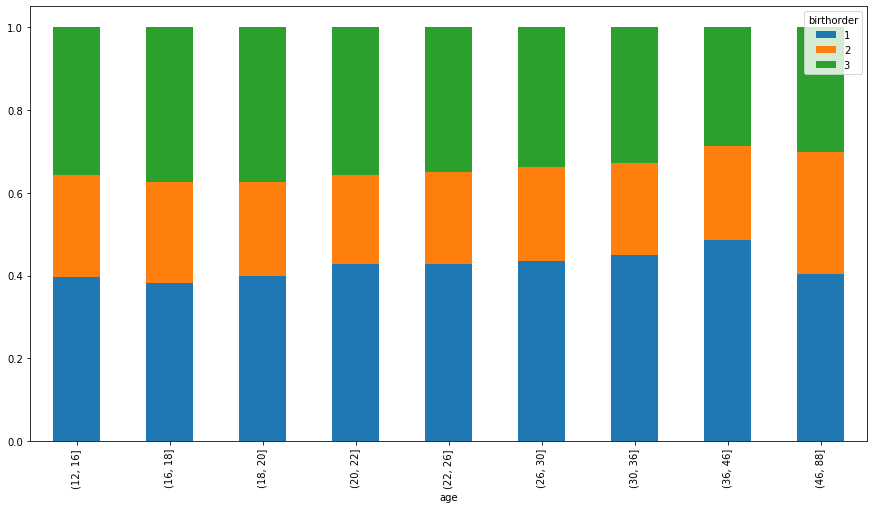

In [34]:
birthorder_abbrev_df = birthorder_df[['age', 'birthorder']]
birthorder_abbrev_df.set_index(pd.cut(\
                                  birthorder_abbrev_df['age'],\
                                  [12, 16, 18, 20, 22, 26, 30,\
                                   36, 46, 88]), inplace=True)
agegroup_birthorder_counts_s = birthorder_abbrev_df.\
                            groupby([birthorder_abbrev_df.index,\
                                     'birthorder']).size()
agegroup_counts_s = birthorder_abbrev_df.groupby(\
                                            birthorder_abbrev_df.index)\
                                            ['birthorder'].count()
agegroup_pct_birthorder_s = agegroup_birthorder_counts_s.div(\
                                                    agegroup_counts_s,\
                                                     axis=0,level=0)
agegroup_pct_birthorder_s.unstack().plot.bar(stacked=True,\
                                         figsize=(15,8))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


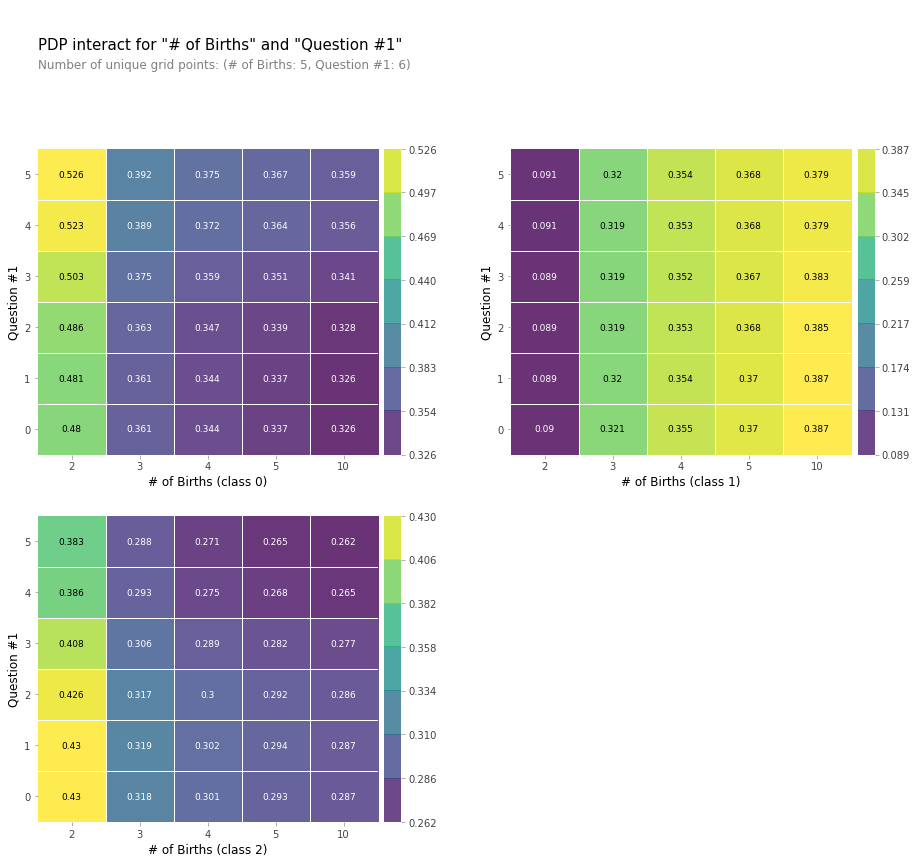

In [35]:
pdp_birthn_Q1_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],\
    dataset=pd.concat((X_test, y_test), axis=1),\
    model_features=X_test.columns, features=['birthn','Q1'],\
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_birthn_Q1_df,\
    plot_type='grid', x_quantile=True,\
    ncols=2, figsize=(15,15),\
    feature_names=['# of Births','Question #1']
)

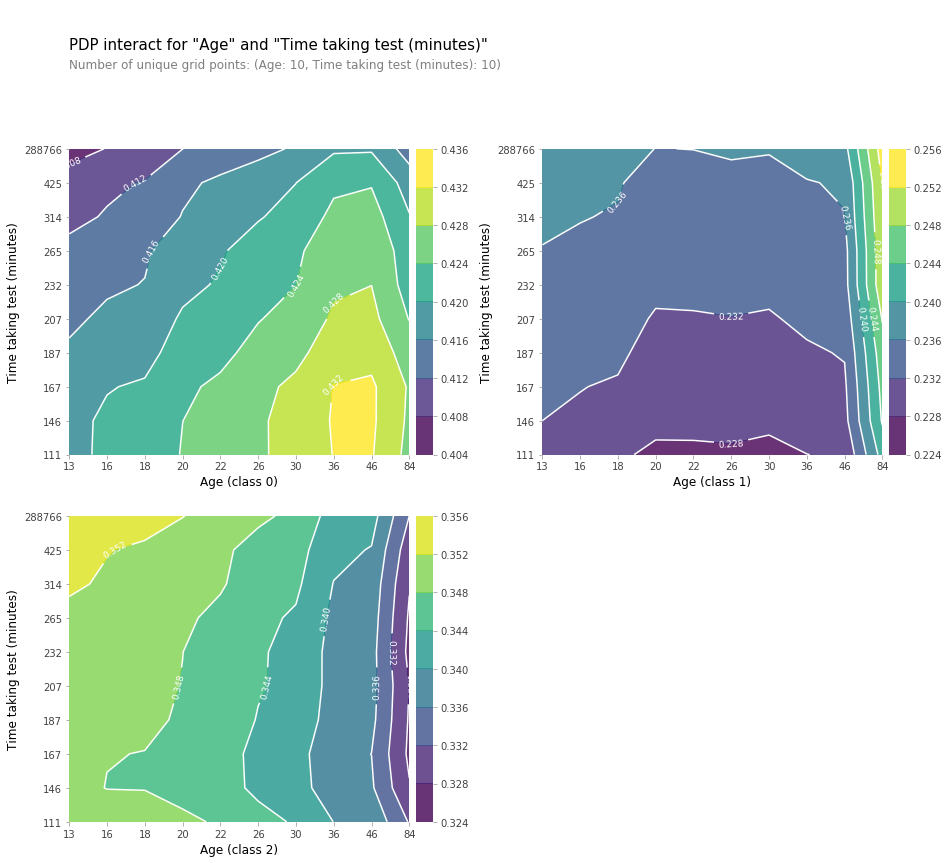

In [36]:
pdp_age_testelapse_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],\
    dataset=pd.concat((X_test, y_test), axis=1),\
    model_features=X_test.columns, features=['age','testelapse'],\
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_age_testelapse_df,\
    plot_type='contour', x_quantile=True,\
    ncols=2, figsize=(15,15),\
    feature_names=['Age','Time taking test (minutes)']
)

In [37]:
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(\
                    X_test.shape[0],\
                    math.ceil(X_test.shape[0]*sample_size),\
                    replace=False)
X_test_samp = X_test.iloc[sample_idx,:]

In [38]:
def predict_prob_first_born(test_df):
    return class_models['random_forest']['fitted'].\
                                predict_proba(test_df)[:,0]
def predict_prob_middle_child(test_df):
    return class_models['random_forest']['fitted'].\
                                predict_proba(test_df)[:,1]
def predict_prob_last_born(test_df):
    return class_models['random_forest']['fitted'].\
                                predict_proba(test_df)[:,2]

In [39]:
legend_key = {0:'N/A', 1:'Disagree', 2:'Somewhat Disagree',
              3:'Neutral', 4:'Somewhat Agree', 5:'Agree'}

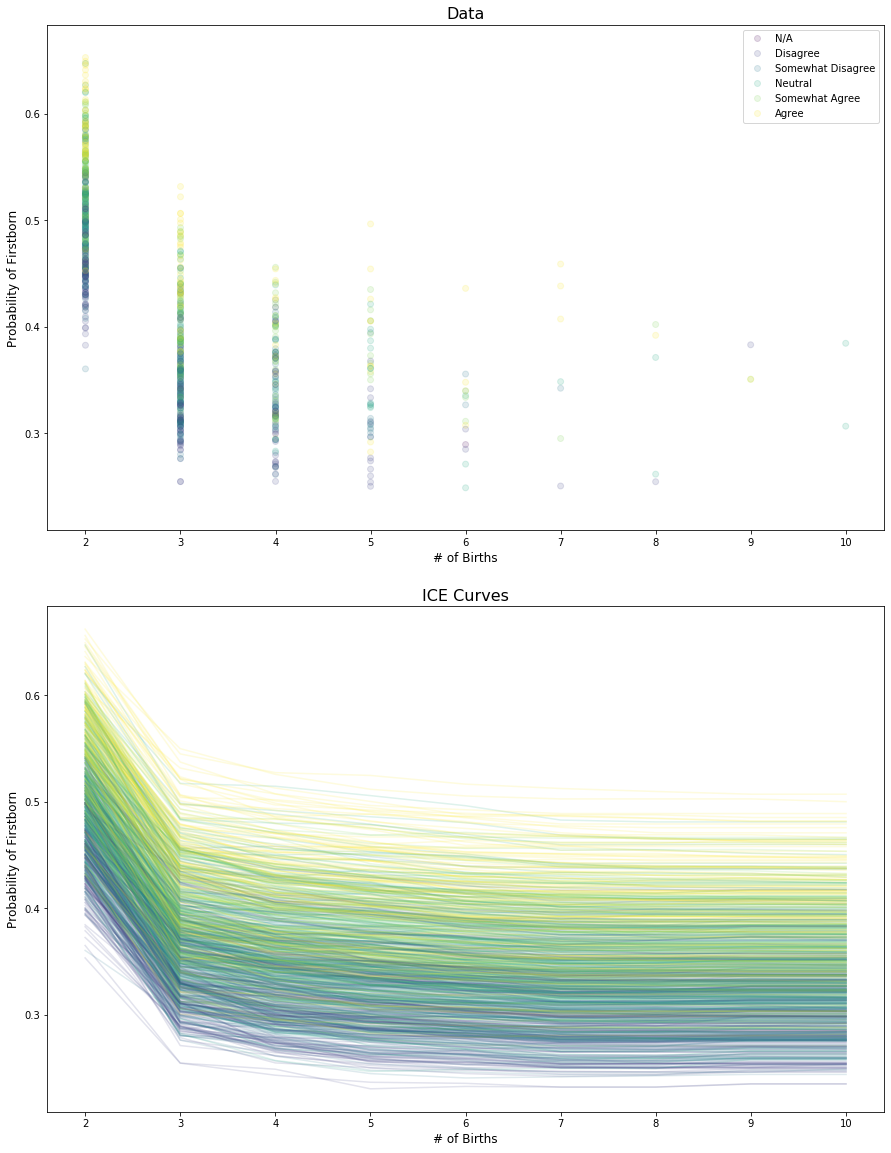

In [40]:
mldatasets.plot_data_vs_ice(predict_prob_first_born,\
                            'Probability of Firstborn',\
                            X=X_test_samp, feature_name='birthn',\
                            feature_label='# of Births',\
                            color_by='Q1', legend_key=legend_key)

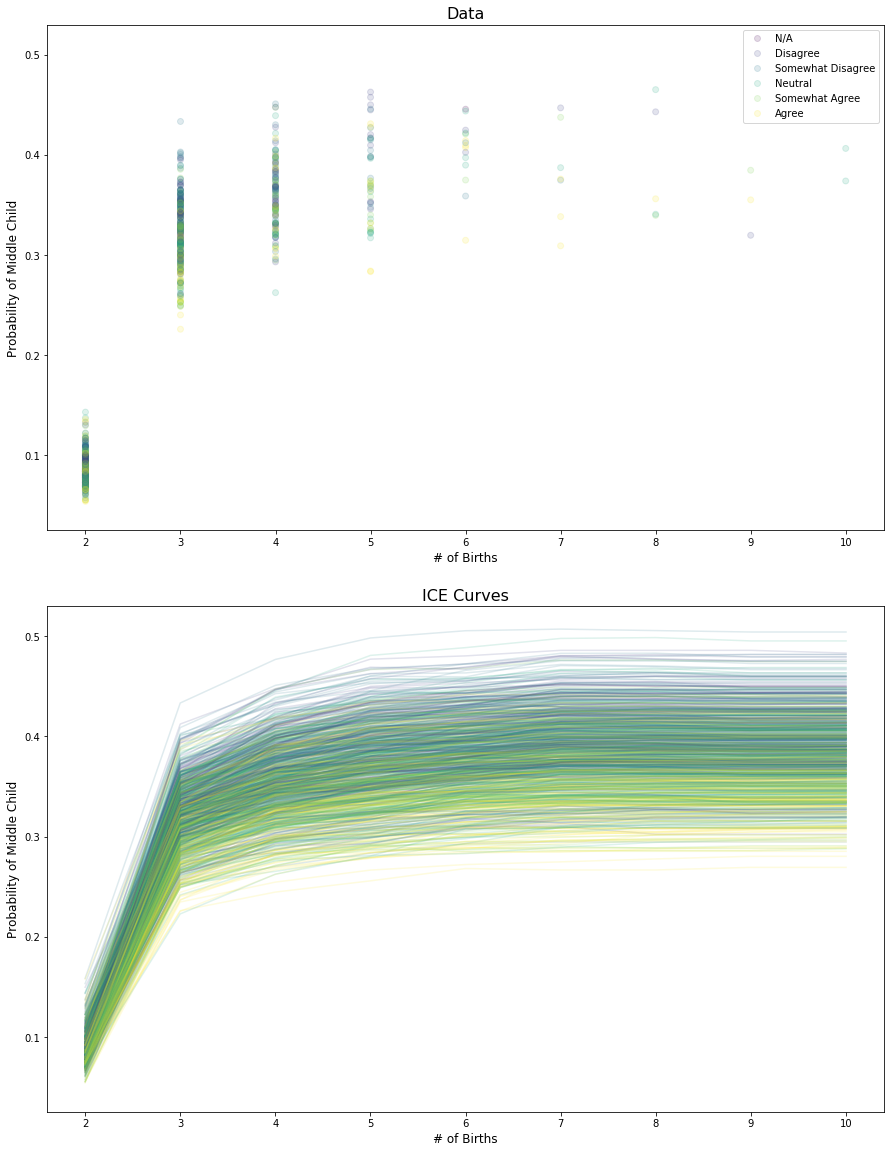

In [41]:
mldatasets.plot_data_vs_ice(predict_prob_middle_child,\
                            'Probability of Middle Child',\
                            X=X_test_samp, feature_name='birthn',\
                            feature_label='# of Births',\
                            color_by='Q1', legend_key=legend_key)

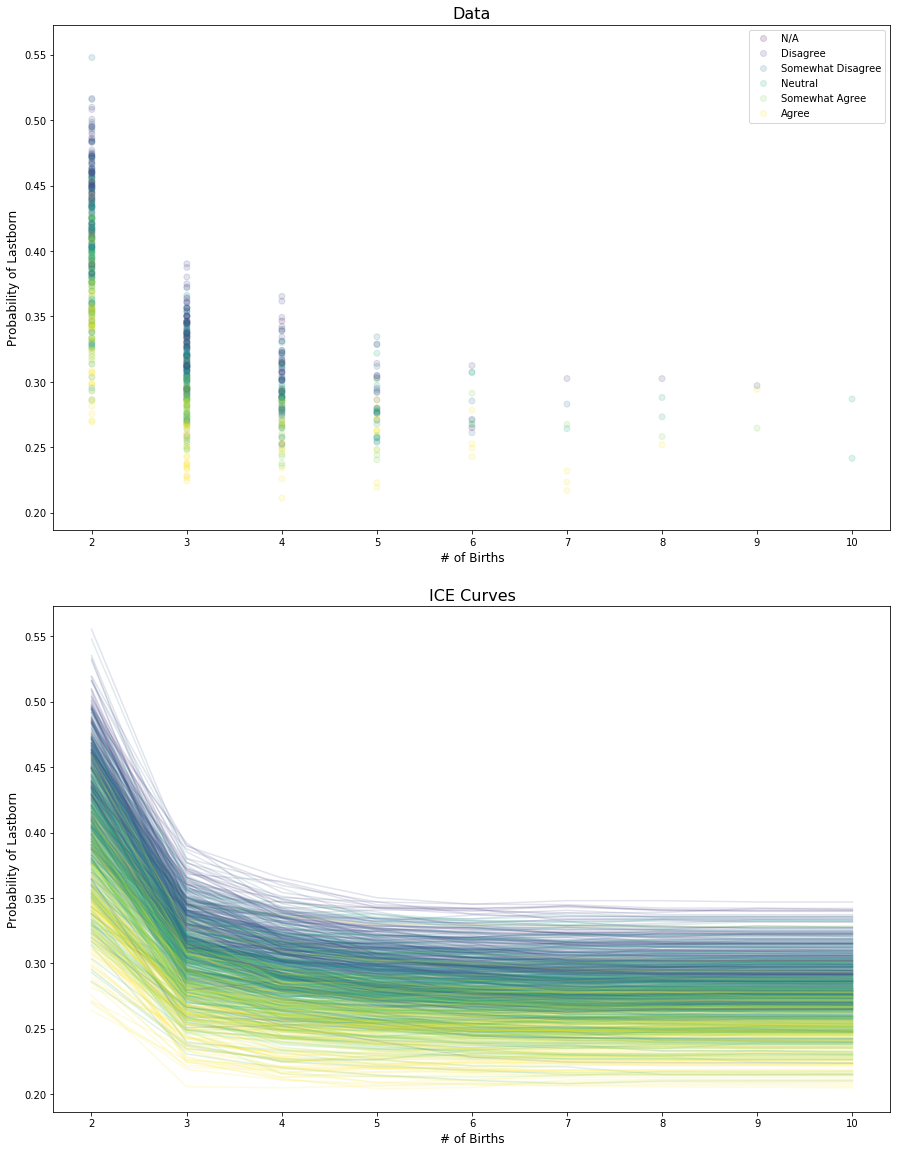

In [42]:
mldatasets.plot_data_vs_ice(predict_prob_last_born,\
                            'Probability of Lastborn',\
                            X=X_test_samp, feature_name='birthn',\
                            feature_label='# of Births',\
                            color_by='Q1', legend_key=legend_key)